In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [ ]:
data_folder_location = 'data/'

# Импорт данных о генерации электроэнергии и данных датчиков погоды
plant1_generation_data = pd.read_csv(
    data_folder_location + 'Plant_1_Generation_Data.csv', index_col=False)
plant2_generation_data = pd.read_csv(
    data_folder_location + 'Plant_2_Generation_Data.csv', index_col=False)

# Импорт данных датчиков погоды
plant1_weather_sensor_data = pd.read_csv(
    data_folder_location + 'Plant_1_Weather_Sensor_Data.csv', index_col=False)
plant2_weather_sensor_data = pd.read_csv(
    data_folder_location + 'Plant_2_Weather_Sensor_Data.csv', index_col=False)

In [ ]:
# Сохранение только необходимых данных
plant2_generation_Time = plant2_generation_data.groupby(
    ['DATE_TIME'], as_index=False).sum()
plant2_generation_Time = plant2_generation_Time[[
    'DATE_TIME', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD']]

<ipython-input-99-da713148afe4>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ['DATE_TIME'], as_index=False).sum()


In [ ]:
# Сохранение только необходимых данных
plant2_weather_sensor_data1 = plant2_weather_sensor_data.drop(
    ['PLANT_ID', 'SOURCE_KEY'], axis=1)

# Объединение данных о солнечной генерации установки 2 и данных о погоде
merged_data_plant2 = pd.merge(
    plant2_generation_Time, plant2_weather_sensor_data1, how='inner', on='DATE_TIME')

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import check_array
import xgboost as xgb
from xgboost import plot_importance
plt.style.use('fivethirtyeight')

In [ ]:
target = merged_data_plant2['AC_POWER']
features = merged_data_plant2[['IRRADIATION', 'AMBIENT_TEMPERATURE']]

In [ ]:
# Разделение данных на обучающую и тестовую выборки
#scaler = MinMaxScaler(feature_range=(0, 1))
#features_norm = scaler.fit_transform(features)
#target_norm = scaler.fit_transform(target)
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=5)

In [ ]:
#Прогнозирование с помощью линейной регрессии
lm = linear_model.LinearRegression()
model_lm = lm.fit(X_train, y_train)
pred_y_test_lm = lm.predict(X_test)

In [ ]:
#  Вычисление MSE, MAE и MAPE для оценки ошибки модели
R2_lm = r2_score(y_test, pred_y_test_lm)
mse_lm = mean_squared_error(y_test, pred_y_test_lm, squared=False)
mae_lm = mean_absolute_error(y_test, pred_y_test_lm)


def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))


mase_lm = mean_absolute_scaled_error(y_test, pred_y_test_lm, y_train)


print('R2 с использованием линейной регрессии:', R2_lm, ' ' 'RMSE с использованием линейной регрессии:', mse_lm,
'\n ' 'MAE с использованием линейной регрессии:', mae_lm, ' ' 'MASE с использованием линейной регрессии:', mase_lm)

R2 с использованием линейной регрессии: 0.8331420997408431  RMSE с использованием линейной регрессии: 2482.9999855124343 
 MAE с использованием линейной регрессии: 1577.5537872942864  MASE с использованием линейной регрессии: 0.24768773390073837


In [ ]:
config = xgb.get_config()
config

{'use_rmm': False, 'verbosity': 1}

In [ ]:
# Обучение модели XG Boost на наборе данных о генерации солнечной энергии
model_xgb = xgb.XGBRegressor(n_estimators=50)
model_xgb.fit(X_train, y_train,
              eval_set=[(X_train, y_train),
                        (X_test, y_test)],
              early_stopping_rounds=50,
              verbose=False)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

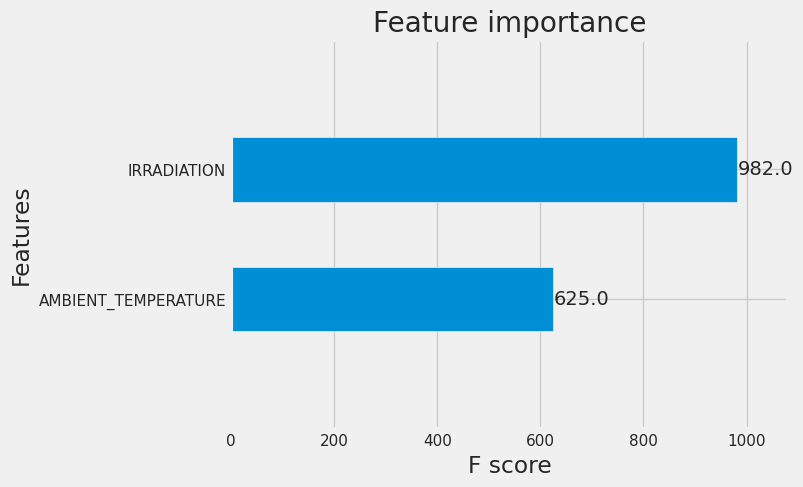

In [ ]:
# Построение графика значимости признаков для прогнозирования
_ = plot_importance(model_xgb, height=0.5)

In [ ]:
pred_y_test_xgb = model_xgb.predict(X_test)

In [ ]:
# Вычисление MSE (среднеквадратичная ошибка), MAE (средняя абсолютная ошибка) и MAPE (средняя абсолютная процентная ошибка) для прогнозируемых значений с целью оценки ошибки модели
R2_xgb = r2_score(y_test, pred_y_test_xgb)
mse_xgb = mean_squared_error(y_test, pred_y_test_xgb, squared=False)
mae_xgb = mean_absolute_error(y_test, pred_y_test_xgb)
mase_xgb = mean_absolute_scaled_error(y_test, pred_y_test_xgb, y_train)

print('R2 с использованием XGBoost:', R2_xgb, ' ' 'RMSE с использованием XGBoost:', mse_xgb,
'\n ' 'MAE с использованием XGBoost:', mae_xgb, ' ' 'MASE с использованием XGBoost:', mase_xgb)

R2 с использованием XGBoost: 0.9020792863295167  RMSE с использованием XGBoost: 1902.1318384925057 
 MAE с использованием XGBoost: 820.604295959098  MASE с использованием XGBoost: 0.12884100696428655


In [ ]:
# Определение конвейера (Pipeline) и сетки параметров (Parameter grid)
pipeline = Pipeline([
    ('model', model_xgb)
])

param_grid = {
    'model__max_depth': [2, 3, 5, 7],
    'model__n_estimators': [10, 50, 100],
    'model__learning_rate': [0.02, 0.05, 0.1, 0.3],
    'model__min_child_weight': [0.5, 1, 2]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)

In [ ]:
# Обучение модели
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     interaction_constraints=...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=50,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.02, 0.05, 0.1, 0.3],
                         'model__max_depth': [2, 3, 5, 7],
                         'model__min_child_weight': [0.5, 1, 2],
                         'model__n_estimators': [10, 50, 100]})

In [ ]:
# Вывод лучших параметров для модели, определенных с помощью Gridsearch
print(f"Лучшие параметры: {grid.best_params_}")

Лучшие параметры: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__min_child_weight': 2, 'model__n_estimators': 100}


In [ ]:
# Прогнозирование с помощью Gridsearch
pred_y_test_xgb_grid = grid.predict(X_test)

In [ ]:
# Вычисление MSE (среднеквадратичная ошибка), MAE (средняя абсолютная ошибка) и MAPE (средняя абсолютная процентная ошибка) для прогнозируемых значений с целью оценки ошибки модели
R2_xgb_grid = r2_score(y_test, pred_y_test_xgb_grid)
mse_xgb_grid = mean_squared_error(y_test, pred_y_test_xgb_grid, squared=False)
mae_xgb_grid = mean_absolute_error(y_test, pred_y_test_xgb_grid)
mase_xgb_grid = mean_absolute_scaled_error(
    y_test, pred_y_test_xgb_grid, y_train)

print('R2 с использованием модели XGB_grid:', R2_xgb_grid, ' ' 'RMSE с использованием модели XGB_grid:', mse_xgb_grid,
'\n ' 'MAE с использованием модели XGB_grid:', mae_xgb_grid, ' ' 'MASE с использованием модели XGB_grid:', mase_xgb_grid)

R2 с использованием модели XGB_grid: 0.9152617389788107  RMSE с использованием модели XGB_grid: 1769.4695912899797 
 MAE с использованием модели XGB_grid: 823.8470637108431  MASE с использованием модели XGB_grid: 0.12935014573499926


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Разделение нормализованных данных на обучающую и тестовую выборки
scaler = MinMaxScaler(feature_range=(0, 1))
features_norm = scaler.fit_transform(features)
#target_norm = scaler.fit_transform(target)
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    features_norm, target, test_size=0.3, random_state=5)

In [ ]:

y_test


1728       0.000000
2039    3584.544286
0          0.000000
2270    4084.562381
2332    9764.805238
           ...     
2119       0.000000
87         0.000000
447      705.962500
1626       0.000000
3054       0.000000
Name: AC_POWER, Length: 978, dtype: float64

In [ ]:
pred_y_test_lm

In [ ]:
pred_y_test_xgb

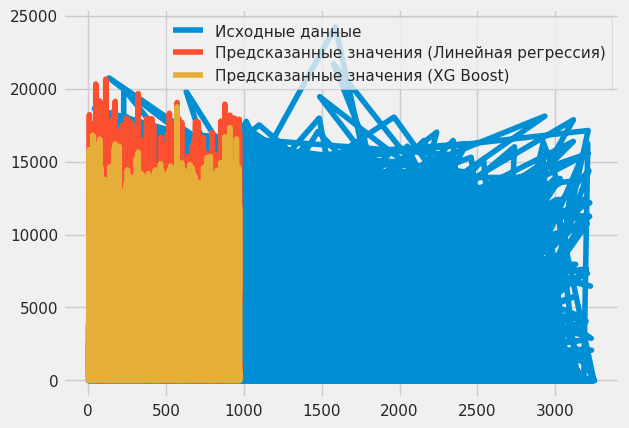

In [ ]:
# Визуализация исходных данных и предсказанных значений
plt.plot(y_test, label='Исходные данные')
plt.plot(pred_y_test_lm, label='Предсказанные значения (Линейная регрессия)')
plt.plot(pred_y_test_xgb, label='Предсказанные значения (XG Boost)')
plt.legend()
plt.show()